<a href="https://colab.research.google.com/github/anutitto/dissertation/blob/main/fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285397 sha256=5d73b072bfb156d60785bb99de6abe6ca1a855f02f7bdd58745214138f009386
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [3]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,isnan,when,count
spark = SparkSession.builder.appName("fraud_detection_financialtransactions").getOrCreate()
df = spark.read.csv('dataset.csv', header=True, inferSchema=True)
df.printSchema()
df.summary().show()
df2 = df.select([count(when(col(c).contains('Unknown') | \
                            col(c).contains('N/A') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c
                           )).alias(c)
                    for c in df.columns])
df2.show()


root
 |-- Time: integer (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (null

In [ ]:
from pyspark.sql.functions import desc, row_number, monotonically_increasing_id
from pyspark.sql.window import Window

df_new = df.withColumn('id', row_number().over(Window.orderBy(monotonically_increasing_id())))
df_new.show()

+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+------+-----+---+
|Time|       V1|       V2|       V3|       V4|       V5|       V6|       V7|       V8|       V9|      V10|      V11|      V12|      V13|      V14|      V15|      V16|      V17|      V18|      V19|      V20|      V21|      V22|      V23|      V24|      V25|      V26|      V27|      V28|Amount|Class| id|
+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+------+-----+---+
|   0|-1.359807|-0.072781| 2.536347| 1.378155|-0.338321| 0.462388| 0.239599| 0.098698| 0

In [ ]:
df_new=df_new.select('id','Time','V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','Amount','Class')
df_new.show()

+---+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+------+-----+
| id|Time|       V1|       V2|       V3|       V4|       V5|       V6|       V7|       V8|       V9|      V10|      V11|      V12|      V13|      V14|      V15|      V16|      V17|      V18|      V19|      V20|      V21|      V22|      V23|      V24|      V25|      V26|      V27|Amount|Class|
+---+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+------+-----+
|  1|   0|-1.359807|-0.072781| 2.536347| 1.378155|-0.338321| 0.462388| 0.239599| 0.098698| 0.363787| 0.090794|  -0.551

In [ ]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler().setInputCols\
            (df_new.columns).setOutputCol("features")
transformed = assembler.transform(df_new)
scaler = MinMaxScaler(inputCol="features",\
         outputCol="scaledFeatures")
scalerModel =  scaler.fit(transformed.select("features"))
scaledData = scalerModel.transform(transformed)
scaledData.show()

+---+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+------+-----+--------------------+--------------------+
| id|Time|       V1|       V2|       V3|       V4|       V5|       V6|       V7|       V8|       V9|      V10|      V11|      V12|      V13|      V14|      V15|      V16|      V17|      V18|      V19|      V20|      V21|      V22|      V23|      V24|      V25|      V26|      V27|Amount|Class|            features|      scaledFeatures|
+---+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+------+-----+--------------------+--------------

In [ ]:
def extract(row):
    return tuple(row.scaledFeatures.toArray().tolist())
final_data = scaledData.select("scaledFeatures").rdd\
               .map(extract).toDF(df_new.columns)
final_data.show()
print(final_data.count(),len(final_data.columns))
final_data=final_data.toPandas()

+--------------------+--------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+------------------+-------------------+------------------+-------------------+------------------+-------------------+------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+-------------------+------------------+-------------------+-------------------+--------------------+-----+
|                  id|                Time|                V1|                V2|                V3|                 V4|                V5|                 V6|                 V7|                V8|                 V9|               V10|                V11|               V12|                V13|               V14|                V15|                V16|               V17|               V18|          

In [ ]:
import pandas as pd
final_data.to_csv("dataset_final.csv",index=False)

In [ ]:
# Oversample and plot imbalanced dataset with SMOTE
from collections import Counter
from imblearn.over_sampling import SMOTE
# define dataset
data_smote=pd.read_csv("dataset_final.csv")
y = data_smote['Class']#dependent variable
X = data_smote.drop(['Class'], axis = 1)#independent variable
smote = SMOTE()
# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X, y)
print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_smote))
data_smote_new = pd.DataFrame(x_smote, columns=X.columns)
data_smote_new['Class'] = y_smote

Original dataset shape Counter({0.0: 284315, 1.0: 492})
Resample dataset shape Counter({0.0: 284315, 1.0: 284315})


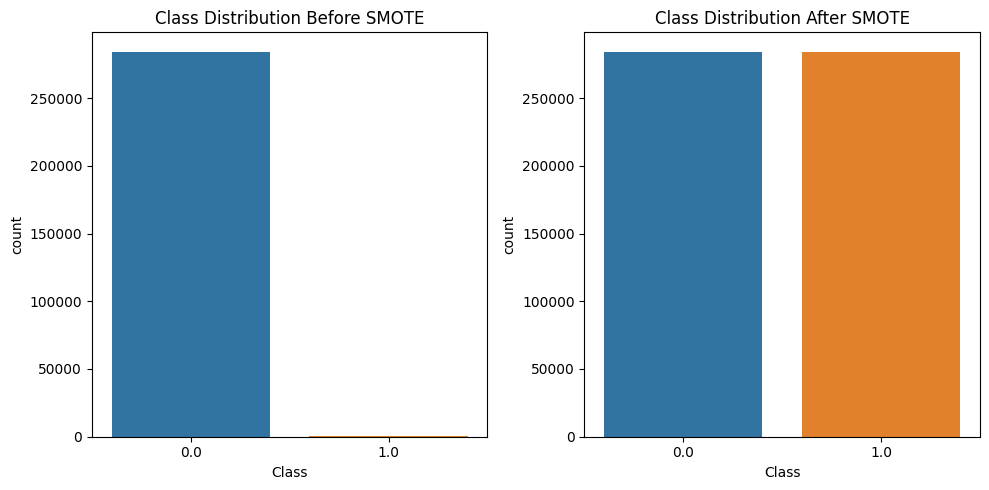

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(121)
g = sns.countplot(x='Class', data=data_smote)
g.set_title('Class Distribution Before SMOTE')

plt.subplot(122)
g_smote = sns.countplot(x='Class', data=data_smote_new)
g_smote.set_title('Class Distribution After SMOTE')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
X = data_smote_new.drop(['Class'],axis=1)
y = data_smote_new["Class"]
#create subset of the dataset
subset_size = 0.1
X_subset, _, y_subset, _ = train_test_split(X, y, train_size=subset_size, random_state=42)
# Create training and test split
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)
svc = SVC(C=1.0, random_state=42, kernel='linear')

# Fit the model
svc.fit(X_train, y_train)


SVC(kernel='linear', random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions on the test set
y_predict = svc.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_predict)
print(f"Accuracy: {accuracy:.2f}")

# Get a classification report
print("Classification Report:")
print(classification_report(y_test, y_predict))

# Get a confusion matrix
print("Confusion Matrix:")
cm=confusion_matrix(y_test, y_predict)
print(cm)

Accuracy: 0.95
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95      5746
         1.0       0.98      0.91      0.94      5627

    accuracy                           0.95     11373
   macro avg       0.95      0.95      0.95     11373
weighted avg       0.95      0.95      0.95     11373

Confusion Matrix:
[[5653   93]
 [ 517 5110]]


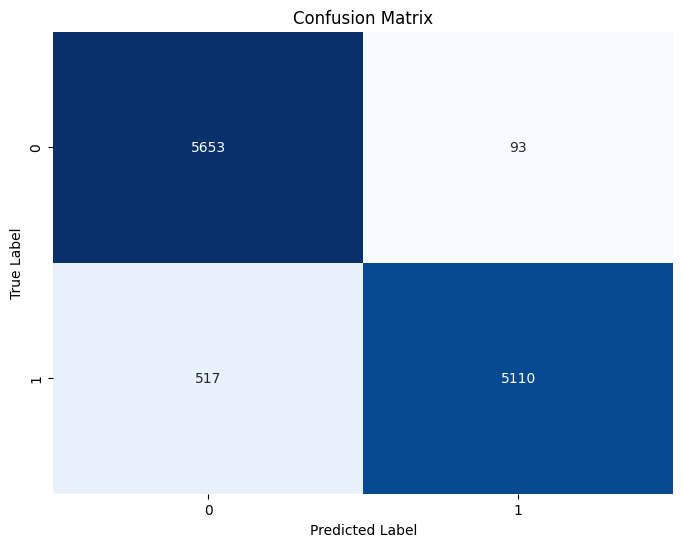

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions on the test set
y_predict = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_predict)
print(f"Accuracy: {accuracy:.2f}")

# Get a classification report
print("Classification Report:")
print(classification_report(y_test, y_predict))

# Get a confusion matrix
print("Confusion Matrix:")
cm_rf=confusion_matrix(y_test, y_predict)
print(cm_rf)

Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5746
         1.0       1.00      1.00      1.00      5627

    accuracy                           1.00     11373
   macro avg       1.00      1.00      1.00     11373
weighted avg       1.00      1.00      1.00     11373

Confusion Matrix:
[[5738    8]
 [   7 5620]]


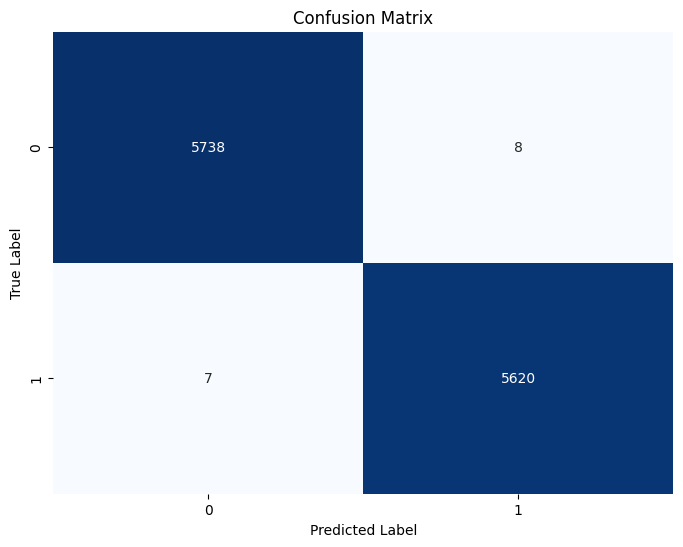

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.metrics import Accuracy
# Create the ANN model
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[Accuracy()])

# Train the model on the training data
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)


Epoch 1/10
1280/1280 [==============================] - 4s 2ms/step - loss: 0.2251 - accuracy: 0.0074 - val_loss: 0.1661 - val_accuracy: 0.0374
Epoch 2/10
1280/1280 [==============================] - 5s 4ms/step - loss: 0.1549 - accuracy: 0.0515 - val_loss: 0.1691 - val_accuracy: 0.0578
Epoch 3/10
1280/1280 [==============================] - 3s 2ms/step - loss: 0.1492 - accuracy: 0.0532 - val_loss: 0.1956 - val_accuracy: 0.0409
Epoch 4/10
1280/1280 [==============================] - 3s 2ms/step - loss: 0.1494 - accuracy: 0.0509 - val_loss: 0.1379 - val_accuracy: 0.0508
Epoch 5/10
1280/1280 [==============================] - 3s 3ms/step - loss: 0.1444 - accuracy: 0.0503 - val_loss: 0.1366 - val_accuracy: 0.0528
Epoch 6/10
1280/1280 [==============================] - 5s 4ms/step - loss: 0.1432 - accuracy: 0.0534 - val_loss: 0.1343 - val_accuracy: 0.0440
Epoch 7/10
1280/1280 [==============================] - 3s 2ms/step - loss: 0.1430 - accuracy: 0.0481 - val_loss: 0.1350 - val_accuracy:

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


356/356 [==============================] - 3s 9ms/step
Accuracy: 0.95
